## Scalability Testing

In [1]:
import numpy as np
import time
from tqdm import tqdm
from mpe2 import simple_spread_v3
from Failure_API.src.failure_api.wrappers.communication_wrapper import CommunicationWrapper
from Failure_API.src.failure_api.communication_models.probabilistic_model import ProbabilisticModel
from Failure_API.src.failure_api.communication_models.markov_model import BaseMarkovModel
from pettingzoo.utils.conversions import aec_to_parallel  # if needed

# Utility function to create failure model
def get_failure_model(model_name, agent_ids, failure_prob=0.5):
    if model_name == "probabilistic":
        return ProbabilisticModel(agent_ids=agent_ids, failure_prob=failure_prob)
    elif model_name == "markov":
        return BaseMarkovModel(agent_ids=agent_ids)
    else:
        raise ValueError("Unsupported model")


In [2]:
def run_scalability_test(agent_count, model_name, episodes=30, max_cycles=25, failure_prob=0.5):
    env = simple_spread_v3.env(N=agent_count, max_cycles=max_cycles)
    agent_ids = env.possible_agents
    failure_model = get_failure_model(model_name, agent_ids, failure_prob)

    wrapped_env = CommunicationWrapper(env, failure_models=[failure_model])
    parallel_env = aec_to_parallel(wrapped_env)

    all_rewards = []
    all_step_times = []

    for ep in tqdm(range(episodes), desc=f"{model_name} | Agents={agent_count}"):
        obs, _ = parallel_env.reset()
        total_reward = 0
        step_times = []

        for _ in range(max_cycles):
            actions = {agent: parallel_env.action_space(agent).sample() for agent in parallel_env.agents}
            
            t0 = time.perf_counter()
            obs, rewards, terminations, truncations, infos = parallel_env.step(actions)
            t1 = time.perf_counter()
            
            step_times.append(t1 - t0)
            total_reward += sum(rewards.values())

            if all(terminations.values()) or all(truncations.values()):
                break

        all_rewards.append(total_reward)
        all_step_times.extend(step_times)

    return {
        "agent_count": agent_count,
        "model": model_name,
        "reward_mean": np.mean(all_rewards),
        "step_time_mean": np.mean(all_step_times),
        "total_runtime": np.sum(all_step_times)
    }


In [3]:
results = []

for model_name in ["probabilistic", "markov"]:
    for N in [20, 50]:
        result = run_scalability_test(agent_count=N, model_name=model_name)
        results.append(result)

import pandas as pd
df = pd.DataFrame(results)
from ace_tools import display_dataframe_to_user
display_dataframe_to_user("Scalability Test Results", df)


probabilistic | Agents=20: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it]
probabilistic | Agents=50: 100%|██████████| 30/30 [06:10<00:00, 12.34s/it]
markov | Agents=20: 100%|██████████| 30/30 [03:41<00:00,  7.40s/it]
markov | Agents=50: 100%|██████████| 30/30 [46:20<00:00, 92.69s/it]


ModuleNotFoundError: No module named 'ace_tools'

In [5]:
print(df.head())

   agent_count          model  reward_mean  step_time_mean  total_runtime
0           20  probabilistic -1927.895555        0.055965      41.974087
1           50  probabilistic -9666.349444        0.492616     369.462263
2           20         markov -1897.232983        0.295124     221.342923
3           50         markov -9962.080242        3.703518    2777.638772


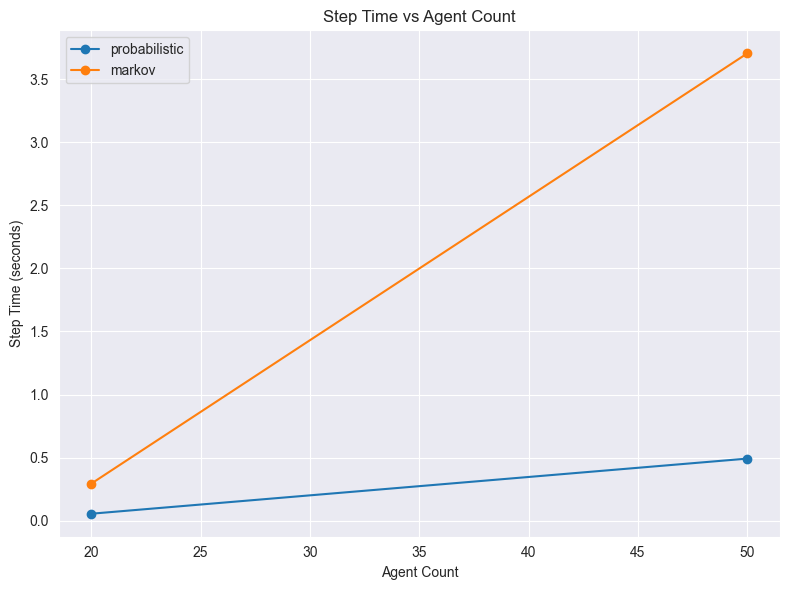

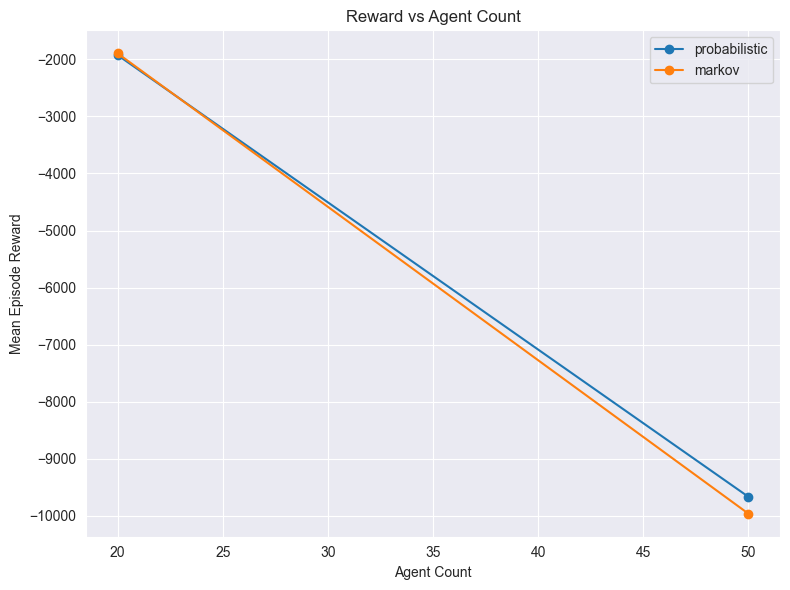

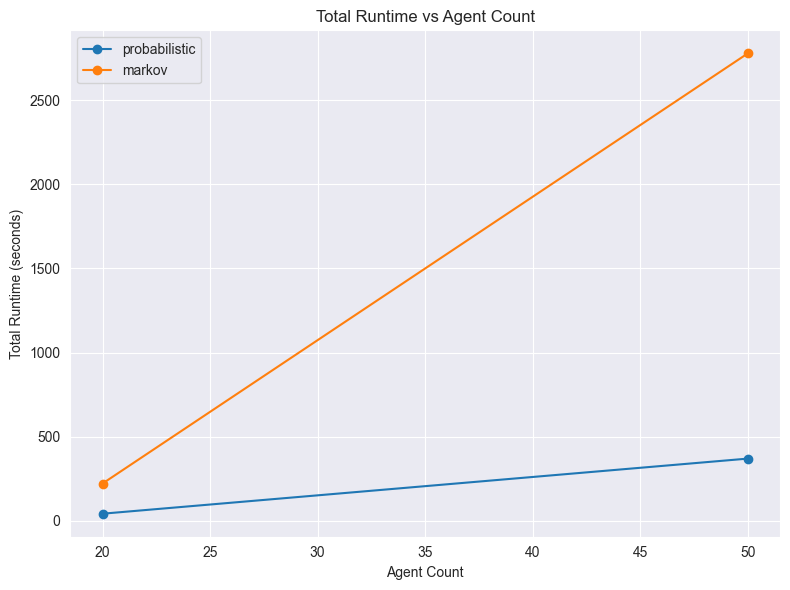

In [6]:

import matplotlib.pyplot as plt
import pandas as pd

# Re-create the result DataFrame
data = {
    "agent_count": [20, 50, 20, 50],
    "model": ["probabilistic", "probabilistic", "markov", "markov"],
    "reward_mean": [-1927.895555, -9666.349444, -1897.232983, -9962.080242],
    "step_time_mean": [0.055965, 0.492616, 0.295124, 3.703518],
    "total_runtime": [41.974087, 369.462263, 221.342923, 2777.638772]
}
df = pd.DataFrame(data)

# Plot 1: Step Time vs Agent Count
plt.figure(figsize=(8, 6))
for model in df["model"].unique():
    subset = df[df["model"] == model]
    plt.plot(subset["agent_count"], subset["step_time_mean"], marker='o', label=model)

plt.title("Step Time vs Agent Count")
plt.xlabel("Agent Count")
plt.ylabel("Step Time (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Reward vs Agent Count
plt.figure(figsize=(8, 6))
for model in df["model"].unique():
    subset = df[df["model"] == model]
    plt.plot(subset["agent_count"], subset["reward_mean"], marker='o', label=model)

plt.title("Reward vs Agent Count")
plt.xlabel("Agent Count")
plt.ylabel("Mean Episode Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Total Runtime vs Agent Count
plt.figure(figsize=(8, 6))
for model in df["model"].unique():
    subset = df[df["model"] == model]
    plt.plot(subset["agent_count"], subset["total_runtime"], marker='o', label=model)

plt.title("Total Runtime vs Agent Count")
plt.xlabel("Agent Count")
plt.ylabel("Total Runtime (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()